### Preliminary Necessities

In [1]:
# Import necessary modules
import mne
import numpy as np
import pandas as pd
import os
from mne.externals.pymatreader import read_mat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set parameters
DATA_DIR = '../data/from_osf'
EEG_DIR = 'EEG'
EXP = 1
SUBJ = 1
ALPHA_BAND = (8, 12)
N_BLOCKS = 3
N_BLOCK_ITERS = 10
IEM_N_CHANNELS = 8
IEM_FEAT_SPACE_RANGE = (0, 359)
IEM_BASIS_FUNC = lambda theta: np.sin(0.5 * np.radians(theta)) ** 7 
FEATURE_NAME = 'Spatial Location'


### Load Data from MAT Files

In [3]:
# Load EEG data for one subject
eeg_mat_fname = os.path.join(DATA_DIR, 'exp{}'.format(EXP), EEG_DIR, '{}_EEG.mat'.format(SUBJ))
eeg_data = read_mat(eeg_mat_fname)['eeg']
info = mne.create_info(eeg_data['chanLabels'], eeg_data['sampRate'], ch_types='eeg')
epochs = mne.EpochsArray(
    eeg_data['data'], info, tmin=eeg_data['preTime'] / 1000).drop(
        eeg_data['arf']['artIndCleaned'].astype(bool))
n_channels, n_timepts = epochs.get_data().shape[-2:]
assert epochs.times[-1] == eeg_data['postTime'] / 1000

# Load behavioral data for one subject
beh_mat_fname = os.path.join(DATA_DIR, 'exp{}'.format(EXP), 'Data', '{}_MixModel_wBias.mat'.format(SUBJ))
beh_data = read_mat(beh_mat_fname)['beh']['trial']
beh_data_cleaned = {k: val[~eeg_data['arf']['artIndCleaned'].astype(bool)] for k, val in beh_data.items()}
pos_bins = beh_data_cleaned['posBin']

Not setting metadata
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dropped 151 epochs: 2, 42, 71, 78, 83, 102, 108, 111, 115, 124, 129, 134, 154, 160, 164, 175, 176, 184, 205, 207, 210, 211, 217, 218, 221, 222, 223, 224, 225, 227, 244, 246, 248, 253, 255, 302, 306, 309, 311, 317, 333, 335, 336, 338, 374, 408, 457, 469, 471, 480, 481, 485, 486, 489, 503, 504, 506, 510, 544, 545, 548, 550, 551, 557, 564, 569, 586, 590, 591, 592, 596, 614, 623, 641, 659, 660, 667, 674, 675, 677, 690, 693, 694, 695, 697, 741, 742, 749, 750, 751, 754, 757, 758, 759, 767, 789, 790, 799, 802, 803, 809, 810, 813, 814, 820, 821, 823, 824, 828, 829, 834, 841, 843, 845, 851, 853, 854, 856, 857, 858, 861, 864, 865, 866, 870, 871, 872, 873, 874, 877, 878, 879, 881, 886, 887, 890, 911, 912, 915, 916, 920, 925, 926, 930, 934, 935, 937, 938, 948, 952, 957


### EEG Preprocessing

In [4]:
# Band-pass filter in alpha band
alpha_band = epochs.copy().filter(*ALPHA_BAND)

# Apply Hilbert transform to get analytic signal
analytic_sig = alpha_band.copy().apply_hilbert()

# Get total power from analytic signal
total_power = analytic_sig.copy().apply_function(np.abs).apply_function(np.square)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 sec)



In [5]:
total_power.get_data().shape

(809, 22, 876)

In [6]:
# Seperate into blocks
blocks = [np.array([]) for _ in range(N_BLOCKS)]
for val in set(pos_bins):
    # Find indices with particular values and randomly permute these indices
    rand_inds = np.random.permutation(np.where(beh_data_cleaned['posBin'] == val)[0])

    # Split these indices into blocks
    blocks_val = np.array_split(rand_inds, N_BLOCKS)

    # Add blocks of particular value to big blocks structure
    blocks = sorted(blocks, key=len)
    blocks = [np.concatenate((block, block_val)) for block, block_val in zip(blocks, blocks_val)]

# Order blocks by length (max difference between any two blocks' length should be 1)
blocks = sorted(blocks, key=len)


In [7]:
# Calculate total power for blocks of trials
n_trials_per_bin = np.bincount(pos_bins - 1).min() // N_BLOCKS * N_BLOCKS
total_power_arr = np.zeros((len(set(pos_bins)) * N_BLOCKS, n_channels, n_timepts), dtype='complex_')

idx_split_by_vals = np.split(np.argsort(pos_bins), np.where(np.diff(sorted(pos_bins)))[0]+1)
for i, val_split in enumerate(idx_split_by_vals):
    idx = np.random.permutation(val_split)[:n_trials_per_bin]
    block_avg = np.mean(total_power.get_data()[idx, :, :].reshape(-1, N_BLOCKS, n_channels, n_timepts), axis=0)
    total_power_arr[i*N_BLOCKS:(i+1)*N_BLOCKS, :, :] = block_avg

In [8]:
class IEM():
    def __init__(self, n_channels=IEM_N_CHANNELS, basis_func=IEM_BASIS_FUNC, feat_space_range=IEM_FEAT_SPACE_RANGE, feature_name=FEATURE_NAME):
        self.n_channels = n_channels
        self.basis_func = basis_func
        self.theta = np.linspace(*feat_space_range, np.diff(feat_space_range)[0] + 1).astype(int)
        self.channel_centers = np.linspace(
            feat_space_range[0], feat_space_range[-1] + 1, self.n_channels + 1)[:-1].astype(int)
        self.basis_set = np.array([np.roll(self.basis_func(self.theta), channel_center - 180) for channel_center in self.channel_centers])
        self.feature_name = feature_name
        self.design_matrix = None
        return
    
    def _gen_design_matrix(self, labels):
        self.design_matrix = np.eye(len(self.theta))[labels] @ self.basis_set.T
        return

    def train_model(self, train_data, train_labels):
        self._gen_design_matrix(train_labels)
        return
        
    def plot_channel_basis_funcs(self):
        df = pd.DataFrame({
            'Angular Location (°)': np.tile(self.theta, self.n_channels), 
            'Peak Response (°)': np.repeat(self.channel_centers, len(self.theta)),
            'Channel Activation': self.basis_set.flatten()})
        g = sns.lineplot(x='Angular Location (°)', y='Channel Activation', hue='Peak Response (°)', data=df)
        g.legend(labels=self.channel_centers, bbox_to_anchor=(1.05, 1), title='Peak Response (°)')

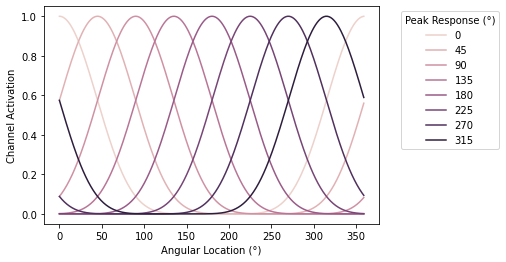

In [9]:
iem = IEM()
iem.plot_channel_basis_funcs()
iem.train_model(total_power, beh_data_cleaned['pos'])